# Notebook for HuggingFaceModelFlow 
## Update system path

In [1]:
%reload_ext autoreload
%autoreload 2

import sys

sys.path.append(".")
sys.path.append("..")
sys.path.append("../..")

## Import dependency

In [2]:
from dotenv import load_dotenv
from IPython.display import display

from uniflow.client import Client
from uniflow.flow.flow_factory import FlowFactory
from uniflow.model.server import ModelServerFactory
from uniflow.config import HuggingfaceConfig
from uniflow.model.config import HuggingfaceModelConfig
from uniflow.viz import Viz

load_dotenv()

/opt/conda/envs/uniflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [3]:
FlowFactory.list()

['LinearFlow',
 'FewShotModelFlow',
 'ModelFlow',
 'OpenAIJsonModelFlow',
 'HuggingFaceModelFlow',
 'LMQGModelFlow']

In [4]:
ModelServerFactory.list()

['OpenAIModelServer', 'HuggingfaceModelServer', 'LMQGModelServer']

## Run model flow to generate data

In [5]:
data = [{
    "instruction": """Generate one question and its corresponding answer based on the context. Following the format of the examples below to include context, question, and answer in the response.""",
    "examples": [
        {
            "context": """The quick brown fox jumps over the lazy dog.""",
            "question": """What is the color of the fox?""",
            "answer": """brown."""
        },
        {
            "context": """The quick brown fox jumps over the lazy black dog.""",
            "question": """What is the color of the dog?""",
            "answer": """black."""
        },
        {
            "context": """It was a sunny day and the sky color is blue.""",
        }
    ],
},
        {
    "instruction": """Generate one question and its corresponding answer based on the context. Following the format of the examples below to include context, question, and answer in the response.""",
    "examples": [
        {
            "context": """The quick brown fox jumps over the lazy dog.""",
            "question": """What is the color of the fox?""",
            "answer": """brown."""
        },
        {
            "context": """The quick brown fox jumps over the lazy black dog.""",
            "question": """What is the color of the dog?""",
            "answer": """black."""
        },
        {
            "context": """My name is bobby and I am a talent software engineer working on AI/ML.""",
        }
    ],
}]


In [6]:
config = HuggingfaceConfig(model_config=HuggingfaceModelConfig(batch_size=1))
client = Client(config)

Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.73s/it]


In [7]:
output = client.run(data)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/envs/uniflow/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')
100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


In [8]:
output

[{'output': [{'response': ["instruction: Generate one question and its corresponding answer based on the context. Following the format of the examples below to include context, question, and answer in the response.\ncontext: The quick brown fox jumps over the lazy dog.\nquestion: What is the color of the fox?\nanswer: brown.\ncontext: The quick brown fox jumps over the lazy black dog.\nquestion: What is the color of the dog?\nanswer: black.\ncontext: It was a sunny day and the sky color is blue.\nquestion: Is it raining outside?\nanswer: No, it's not raining because the sky is blue."],
    'error': 'Failed to deserialize 0 examples'}],
  'root': <uniflow.node.node.Node at 0x7fd739f8d540>},
 {'output': [{'response': ['instruction: Generate one question and its corresponding answer based on the context. Following the format of the examples below to include context, question, and answer in the response.\ncontext: The quick brown fox jumps over the lazy dog.\nquestion: What is the color of

In [15]:
o = output[0]['output'][0]['response'][0]

In [16]:
import re
keywords = ["context:", "question:", "answer:"]
pattern = '|'.join(map(re.escape, keywords))

segments = [segment for segment in re.split(pattern, o) if segment.strip()]
result = {
    "context": segments[-3],
    "question": segments[-2],
    "answer": segments[-1]
}
print(result)


{'context': ' It was a sunny day and the sky color is blue.\n', 'question': ' Is it raining outside?\n', 'answer': " No, it's not raining because the sky is blue."}


## Plot model flow graph

In [17]:
graph = Viz.to_digraph(output[0]['root'])

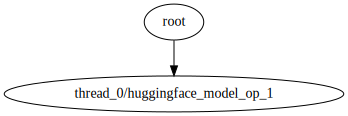

In [18]:
display(graph)

In [19]:
graph = Viz.to_digraph(output[1]['root'])

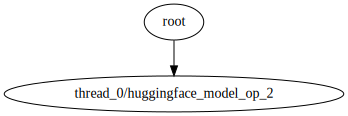

In [20]:
display(graph)